## Домашнее задание №7

1. К алгоритму kNN, представленному на уроке, реализуйте добавление весов для соседей по любому из показанных на уроке принципов. Сравните точность нового алгоритма с исходным при разных значениях `k`.

In [1]:
import numpy as np
from sklearn import model_selection
from sklearn.datasets import load_iris
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

Загрузим один из "игрушечных" датасетов из sklearn.

In [2]:
X, y = load_iris(return_X_y=True)

# Для наглядности возьмем только первые два признака (всего в датасете их 4)
X = X[:, :2]

Разделим выборку на обучающую и тестовую

In [3]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.2, random_state=1)

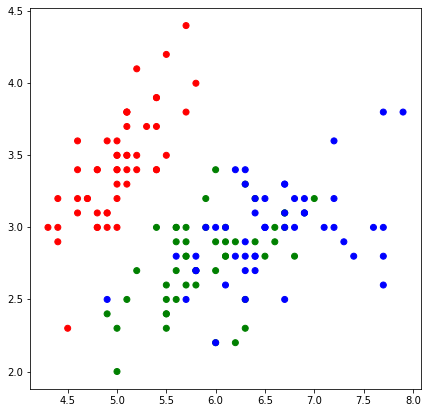

In [4]:
cmap = ListedColormap(['red', 'green', 'blue'])
plt.figure(figsize=(7, 7))
plt.scatter(X[:, 0], X[:, 1], c=y, cmap=cmap);

Используем евклидову метрику. Реализуем функцию для ее подсчета.

In [5]:
def e_metrics(x1, x2):
    distance = 0
    for i in range(len(x1)):
        distance += np.square(x1[i] - x2[i])
    return np.sqrt(distance)

Реализуем алгоритм поиска k ближайших соседей.

In [6]:
def knn(x_train, y_train, x_test, k):
    
    answers = []
    for x in x_test:
        test_distances = []
            
        for i in range(len(x_train)):
            
            # расчет расстояния от классифицируемого объекта до
            # объекта обучающей выборки
            distance = e_metrics(x, x_train[i])
            
            # Записываем в список значение расстояния и ответа на объекте обучающей выборки
            test_distances.append((distance, y_train[i]))
        
        # отберем k ближайших соседей
        k_neighbours = sorted(test_distances)[0:k]
                
        # создаем словарь со всеми возможными классами
        classes = {class_item: 0 for class_item in set(y_train)}
        
        # Сортируем список и среди первых k элементов подсчитаем частоту появления разных классов
        for d in k_neighbours:
            classes[d[1]] += 1 # вес каждого соседа равен 1
            
        # Записываем в список ответов наиболее часто встречающийся класс
        answers.append(sorted(classes, key=classes.get)[-1])
    return answers

Напишем функцию для вычисления точности

In [7]:
def accuracy(pred, y):
    return (sum(pred == y) / len(y))

Построим график распределения классов.

In [8]:
def get_graph(X_train, y_train, k):
    cmap_light = ListedColormap(['#FFAAAA', '#AAFFAA','#00AAFF'])

    h = .02

    # Расчет пределов графика
    x_min, x_max = X_train[:, 0].min() - 1, X_train[:, 0].max() + 1
    y_min, y_max = X_train[:, 1].min() - 1, X_train[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

    # Получим предсказания для всех точек
    Z = knn(X_train, y_train, np.c_[xx.ravel(), yy.ravel()], k)

    # Построим график
    Z = np.array(Z).reshape(xx.shape)
    plt.figure(figsize=(7,7))
    plt.pcolormesh(xx, yy, Z, cmap=cmap_light)

    # Добавим на график обучающую выборку
    plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap=cmap)
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())
    plt.title(f"Трехклассовая kNN классификация при k = {k}")
    plt.show()

Проверим работу алгоритма при различных k

In [9]:
k = [1,3,5,10,20,25]

Точность алгоритма при k = 1: 0.667


<ipython-input-8-a1d024d4c536>:17: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(xx, yy, Z, cmap=cmap_light)


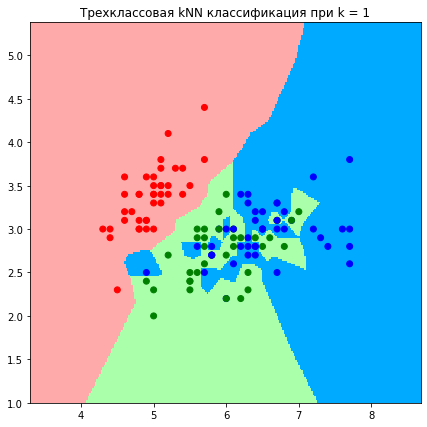

Точность алгоритма при k = 3: 0.733


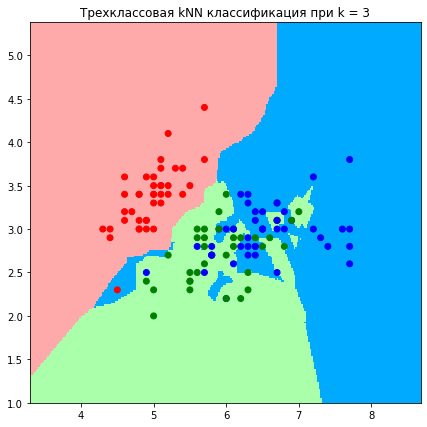

Точность алгоритма при k = 5: 0.867


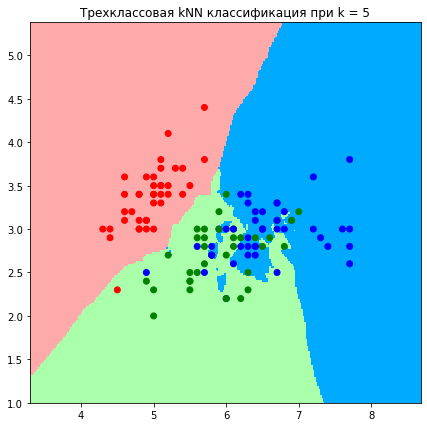

Точность алгоритма при k = 10: 0.833


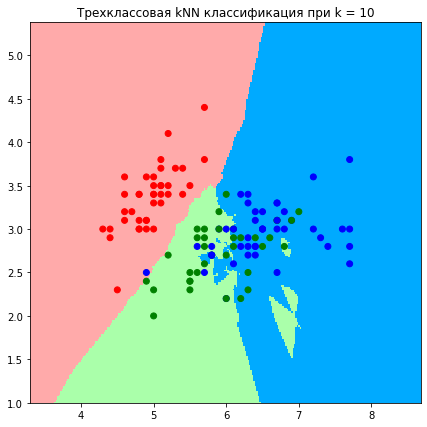

Точность алгоритма при k = 20: 0.833


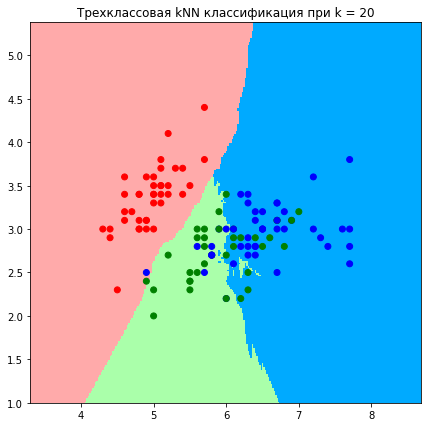

Точность алгоритма при k = 25: 0.800


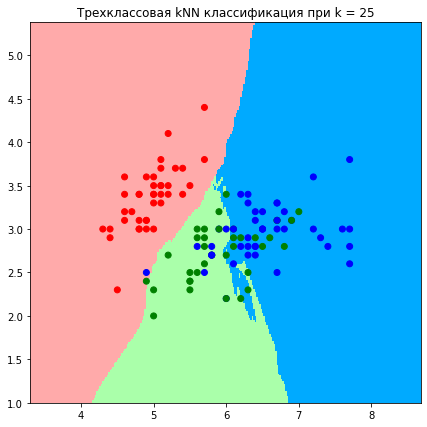

In [10]:
for elem in k:
    y_pred = knn(X_train, y_train, X_test, elem)
    print(f'Точность алгоритма при k = {elem}: {accuracy(y_pred, y_test):.3f}')
    get_graph(X_train, y_train, elem)

Добавим веса для соседей по формуле:

- $w(i) = \frac{1}{i}$;

In [11]:
def knn_mod(x_train, y_train, x_test, k, weight='(lambda i: 1 / i)(i)'):
    
    answers = []
    for x in x_test:
        test_distances = []
            
        for i in range(len(x_train)):
            
            # расчет расстояния от классифицируемого объекта до
            # объекта обучающей выборки
            distance = e_metrics(x, x_train[i])
            
            # Записываем в список значение расстояния и ответа на объекте обучающей выборки
            test_distances.append((distance, y_train[i]))
                
        # отберем k ближайших соседей
        k_neighbours = sorted(test_distances)[0:k]        
        
        # создаем словарь со всеми возможными классами
        classes = {class_item: 0 for class_item in set(y_train)}
    
        # Считаем веса соседей
        w_neighbours = [(eval(weight), d, y)  for i, (d, y) in enumerate(k_neighbours, start=1)]
        
        # Заполняем словарик весами
        for d in w_neighbours:
            classes[d[2]] += d[0]

        # Записываем в список ответов наиболее часто встречающийся класс
        answers.append(sorted(classes, key=classes.get)[-1])
    return answers

In [12]:
def get_graph_mod(X_train, y_train, k, weight='(lambda i: 1 / i)(i)'):
    cmap_light = ListedColormap(['#FFAAAA', '#AAFFAA','#00AAFF'])

    h = .02

    # Расчет пределов графика
    x_min, x_max = X_train[:, 0].min() - 1, X_train[:, 0].max() + 1
    y_min, y_max = X_train[:, 1].min() - 1, X_train[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

    # Получим предсказания для всех точек
    Z = knn_mod(X_train, y_train, np.c_[xx.ravel(), yy.ravel()], k, weight='(lambda i: 1 / i)(i)')

    # Построим график
    Z = np.array(Z).reshape(xx.shape)
    plt.figure(figsize=(7,7))
    plt.pcolormesh(xx, yy, Z, cmap=cmap_light)

    # Добавим на график обучающую выборку
    plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap=cmap)
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())
    plt.title(f"Трехклассовая kNN классификация при k = {k}")
    plt.show()

In [13]:
k = [1,3,5,10,20,25]

Точность алгоритма при k = 1: 0.667


<ipython-input-12-a9f634ed9fb2>:17: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(xx, yy, Z, cmap=cmap_light)


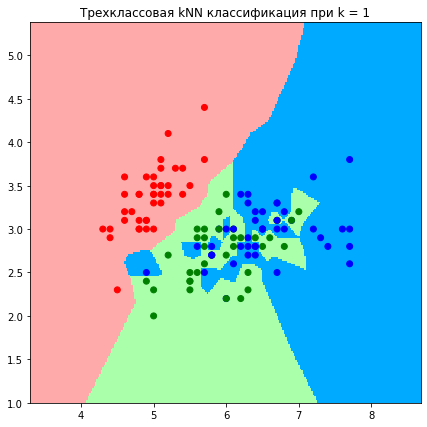

Точность алгоритма при k = 3: 0.667


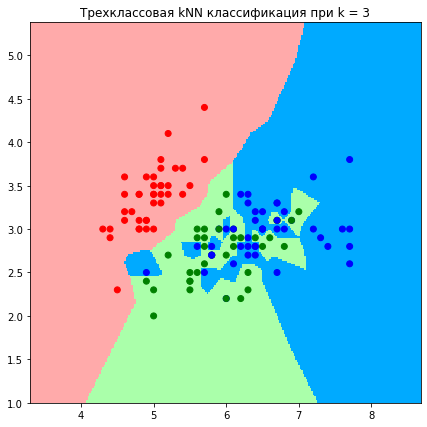

Точность алгоритма при k = 5: 0.733


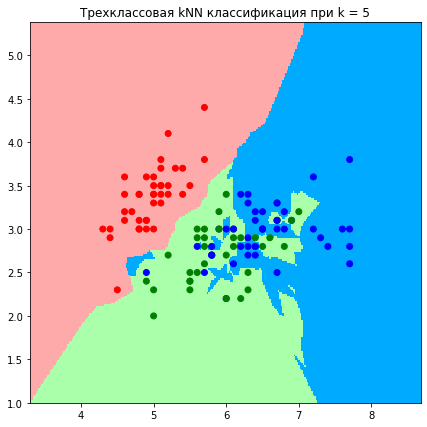

Точность алгоритма при k = 10: 0.767


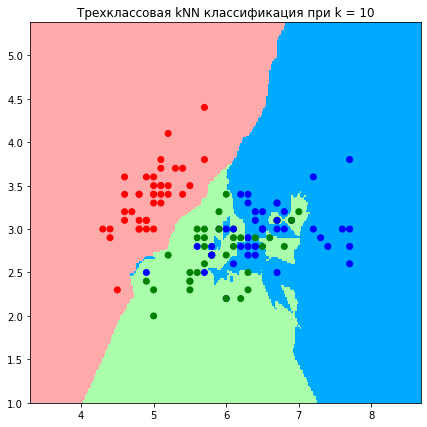

Точность алгоритма при k = 20: 0.800


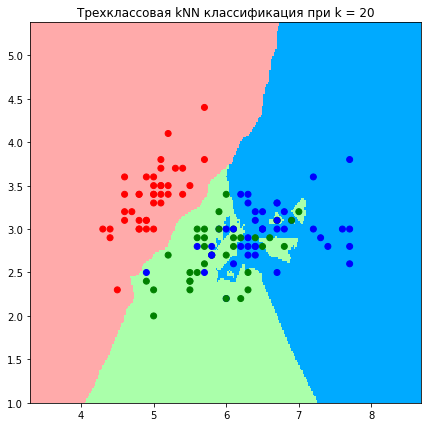

Точность алгоритма при k = 25: 0.800


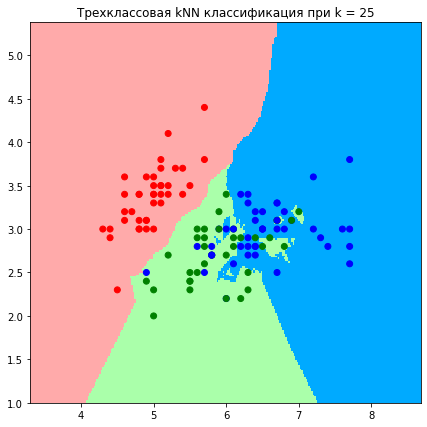

In [14]:
for elem in k:
    y_pred = knn_mod(X_train, y_train, X_test, elem, weight='(lambda i: 1 / i)(i)')
    print(f'Точность алгоритма при k = {elem}: {accuracy(y_pred, y_test):.3f}')
    get_graph_mod(X_train, y_train, elem, weight='(lambda i: 1 / i)(i)')

Результаты расчетов, а также построенная визуализация свидетельствуют о том, что точность алгоритма после добавления весов для соседей при выбранном принципе ($w(i) = \frac{1}{i}$) сначала отстает от точности чистого алгоритма kNN (без весов) при небольшом количестве k (k<10). Первый алгоритм после этого вышел на максимум своей точности, равный 0.833. В дальнейшем при больших k точности двух алгоритмов начинают постепенно сближаться. А при k > 20 точность алгоритма без весов начала падать, в то время как взвешенный вариант вышел на свой максимум при заданных вариантах k, равный 0.800.